C:\Users\HP\AppData\Local\Temp\ipykernel_16856\885148234.py:43: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start = datetime.utcnow() - timedelta(minutes=dt_min*periods)


⚠️ WAQI API failed or no token. Using fully simulated data.
📈 PM2.5 forecast RMSE: 5.09 µg/m³
📈 NO2 forecast RMSE: 4.39 ppb
📈 O3 forecast RMSE: 2.46 ppb
🔆 Solar forecast RMSE: 0.49 kW
📈 Pollution (ppm) forecast RMSE: 7.27 ppm
Most recent 1-hour ahead PM2.5 prediction: 44.0 µg/m³
Most recent 1-hour ahead NO2 prediction: 32.3 ppb
Most recent 1-hour ahead O3 prediction: 1.6 ppb
Air quality category (PM2.5): Unhealthy for Sensitive 😷
🤨 Advice: Air quality is acceptable for most activities.


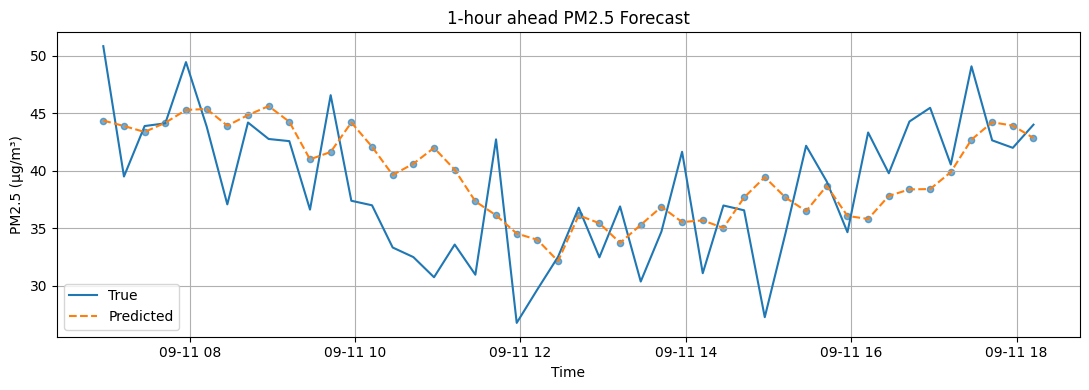

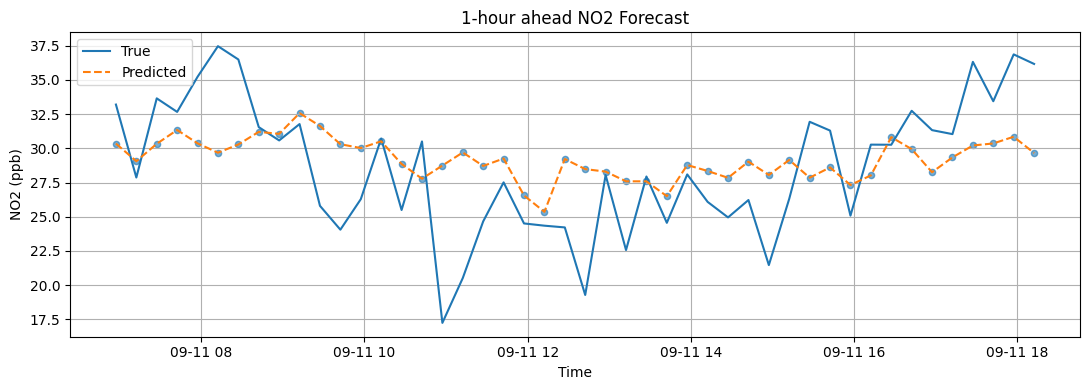

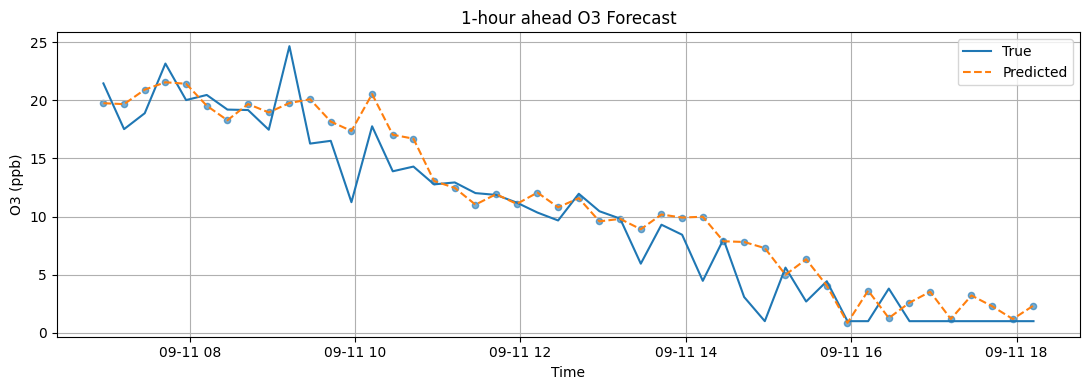

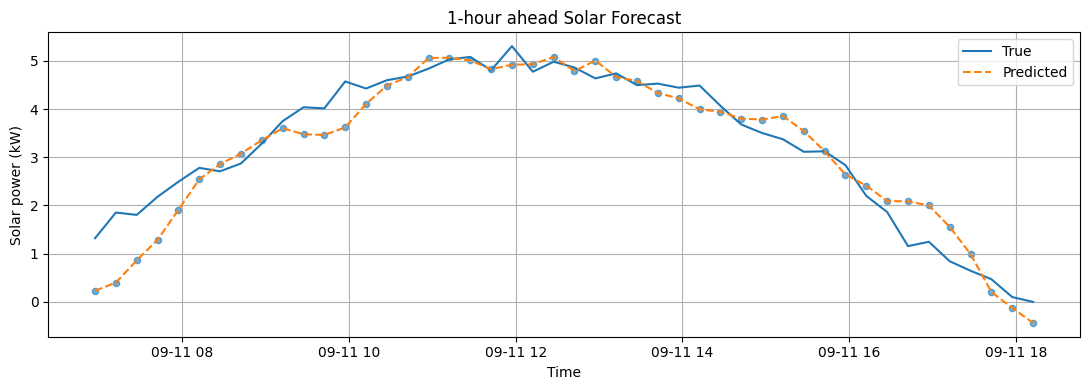

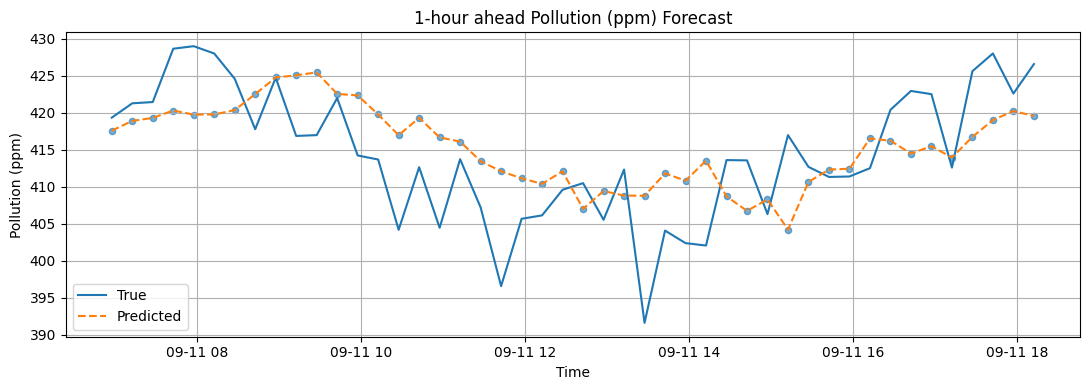

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# CONFIGURATION
WAQI_API_TOKEN = ""  # <- Insert your WAQI API token here
LAT, LON = 25.6, 85.1
HISTORY_HOURS = 48
DT_MIN = 15
LAG = 8
HORIZON = 4
PM25_ALERT_THRESHOLD = 100.0  # µg/m³

# HELPERS: WAQI API fetch & simulation
def fetch_current_pollutants_waqi(lat, lon, token):
    try:
        url = f"https://api.waqi.info/feed/geo:{lat};{lon}/"
        params = {"token": token}
        r = requests.get(url, params=params, timeout=5)
        r.raise_for_status()
        data = r.json()
        if data["status"] == "ok":
            iaqi = data["data"].get("iaqi", {})
            pm25 = iaqi.get("pm25", {}).get("v", None)
            no2 = iaqi.get("no2", {}).get("v", None)
            o3 = iaqi.get("o3", {}).get("v", None)
            return {
                "pm25": float(pm25) if pm25 is not None else None,
                "no2": float(no2) if no2 is not None else None,
                "o3": float(o3) if o3 is not None else None
            }
        else:
            return None
    except Exception:
        return None

def simulate_signals(periods, dt_min=15, seed=42):
    np.random.seed(seed)
    start = datetime.utcnow() - timedelta(minutes=dt_min*periods)
    time_index = [start + timedelta(minutes=dt_min*i) for i in range(periods)]
    hours = np.array([ti.hour + ti.minute/60.0 for ti in time_index])

    solar = 5.0 * np.maximum(0, np.sin((hours - 6) / 12 * np.pi))
    solar += np.random.normal(scale=0.2, size=periods)
    solar = np.clip(solar, 0, None)

    def traffic_factor(h):
        return 0.5 + 0.4 * np.exp(-0.5 * ((h - 8) / 1.5) ** 2) + 0.4 * np.exp(-0.5 * ((h - 18) / 1.5) ** 2)
    traffic = np.array([traffic_factor(h) for h in hours])

    time_hours = np.arange(periods) * (dt_min / 60.0)
    pm25 = 30 + 20 * traffic + 6 * np.sin(2 * np.pi * time_hours / 24) + np.random.normal(scale=4, size=periods)
    pm25 = np.clip(pm25, 1.0, None)

    no2 = 20 + 15 * traffic + 3 * np.sin(2 * np.pi * time_hours / 24) + np.random.normal(scale=3, size=periods)
    no2 = np.clip(no2, 1.0, None)

    o3 = 10 + 10 * np.cos(2 * np.pi * (time_hours - 12) / 24) + np.random.normal(scale=2, size=periods)
    o3 = np.clip(o3, 1.0, None)

    pollution_ppm = 400 + 30 * traffic + 8 * np.sin(2 * np.pi * time_hours / 24) + np.random.normal(scale=5, size=periods)

    return time_index, solar, pm25, no2, o3, pollution_ppm

# BUILD TIME SERIES
periods = int(HISTORY_HOURS * 60 / DT_MIN)
pollutants_live = fetch_current_pollutants_waqi(LAT, LON, WAQI_API_TOKEN)
sim_times, sim_solar, sim_pm25, sim_no2, sim_o3, sim_pollution = simulate_signals(periods, dt_min=DT_MIN, seed=123)

if pollutants_live is not None and pollutants_live["pm25"] is not None:
    print("✅ Using live pollutants from WAQI for the latest value.")
    sim_pm25[-1] = pollutants_live["pm25"]
    if pollutants_live["no2"] is not None:
        sim_no2[-1] = pollutants_live["no2"]
    if pollutants_live["o3"] is not None:
        sim_o3[-1] = pollutants_live["o3"]
else:
    print("⚠️ WAQI API failed or no token. Using fully simulated data.")

df = pd.DataFrame({
    "time": sim_times,
    "solar_kw": sim_solar,
    "pm25": sim_pm25,
    "no2": sim_no2,
    "o3": sim_o3,
    "pollution_ppm": sim_pollution
}).set_index("time")

# FEATURE ENGINEERING
def make_lagged(series, lag=LAG, horizon=HORIZON):
    X, y, times = [], [], []
    arr = np.asarray(series)
    for i in range(len(arr) - lag - horizon + 1):
        X.append(arr[i:i + lag])
        y.append(arr[i + lag + horizon - 1])
        times.append(series.index[i + lag + horizon - 1])
    return np.array(X), np.array(y), times

# Prepare data for each pollutant forecasting
X_pm25, y_pm25, times_pm25 = make_lagged(df["pm25"], lag=LAG, horizon=HORIZON)
X_no2, y_no2, times_no2 = make_lagged(df["no2"], lag=LAG, horizon=HORIZON)
X_o3, y_o3, times_o3 = make_lagged(df["o3"], lag=LAG, horizon=HORIZON)
X_solar, y_solar, times_solar = make_lagged(df["solar_kw"], lag=LAG, horizon=HORIZON)
X_poll, y_poll, times_poll = make_lagged(df["pollution_ppm"], lag=LAG, horizon=HORIZON)

# Check enough data
if len(X_pm25) < 20:
    raise RuntimeError("Not enough data to train (increase HISTORY_HOURS).")

# Split train/test 75/25
split_idx = int(len(X_pm25) * 0.75)

X_pm25_train, y_pm25_train = X_pm25[:split_idx], y_pm25[:split_idx]
X_pm25_test, y_pm25_test = X_pm25[split_idx:], y_pm25[split_idx:]
times_pm25_test = times_pm25[split_idx:]

X_no2_train, y_no2_train = X_no2[:split_idx], y_no2[:split_idx]
X_no2_test, y_no2_test = X_no2[split_idx:], y_no2[split_idx:]
times_no2_test = times_no2[split_idx:]

X_o3_train, y_o3_train = X_o3[:split_idx], y_o3[:split_idx]
X_o3_test, y_o3_test = X_o3[split_idx:], y_o3[split_idx:]
times_o3_test = times_o3[split_idx:]

X_solar_train, y_solar_train = X_solar[:split_idx], y_solar[:split_idx]
X_solar_test, y_solar_test = X_solar[split_idx:], y_solar[split_idx:]
times_solar_test = times_solar[split_idx:]

X_poll_train, y_poll_train = X_poll[:split_idx], y_poll[:split_idx]
X_poll_test, y_poll_test = X_poll[split_idx:], y_poll[split_idx:]
times_poll_test = times_poll[split_idx:]

# TRAIN MODELS
def train_and_predict(X_train, y_train, X_test):
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    return model, y_pred, rmse

model_pm25 = Ridge(alpha=1.0)
model_pm25.fit(X_pm25_train, y_pm25_train)
y_pm25_pred = model_pm25.predict(X_pm25_test)
rmse_pm25 = np.sqrt(mean_squared_error(y_pm25_test, y_pm25_pred))

model_no2 = Ridge(alpha=1.0)
model_no2.fit(X_no2_train, y_no2_train)
y_no2_pred = model_no2.predict(X_no2_test)
rmse_no2 = np.sqrt(mean_squared_error(y_no2_test, y_no2_pred))

model_o3 = Ridge(alpha=1.0)
model_o3.fit(X_o3_train, y_o3_train)
y_o3_pred = model_o3.predict(X_o3_test)
rmse_o3 = np.sqrt(mean_squared_error(y_o3_test, y_o3_pred))

model_solar = Ridge(alpha=1.0)
model_solar.fit(X_solar_train, y_solar_train)
y_solar_pred = model_solar.predict(X_solar_test)
rmse_solar = np.sqrt(mean_squared_error(y_solar_test, y_solar_pred))

model_pollution = Ridge(alpha=1.0)
model_pollution.fit(X_poll_train, y_poll_train)
y_poll_pred = model_pollution.predict(X_poll_test)
rmse_pollution = np.sqrt(mean_squared_error(y_poll_test, y_poll_pred))

print(f"📈 PM2.5 forecast RMSE: {rmse_pm25:.2f} µg/m³")
print(f"📈 NO2 forecast RMSE: {rmse_no2:.2f} ppb")
print(f"📈 O3 forecast RMSE: {rmse_o3:.2f} ppb")
print(f"🔆 Solar forecast RMSE: {rmse_solar:.2f} kW")
print(f"📈 Pollution (ppm) forecast RMSE: {rmse_pollution:.2f} ppm")

# NEXT POLLUTANT PREDICTIONS AND ALERTS
latest_window_pm25 = df["pm25"].values[-LAG:].reshape(1, -1)
next_pm25_pred = model_pm25.predict(latest_window_pm25)[0]

latest_window_no2 = df["no2"].values[-LAG:].reshape(1, -1)
next_no2_pred = model_no2.predict(latest_window_no2)[0]

latest_window_o3 = df["o3"].values[-LAG:].reshape(1, -1)
next_o3_pred = model_o3.predict(latest_window_o3)[0]

def categorize_pm25(val):
    if val <= 15: return "Good 😊"
    elif val <= 35: return "Moderate 🙂"
    elif val <= 55: return "Unhealthy for Sensitive 😷"
    elif val <= 150: return "Unhealthy ⚠"
    else: return "Hazardous 🚨"

def air_quality_advice(pm25, no2, o3):
    # Simple combined advice (you can expand this based on standards)
    if pm25 >= PM25_ALERT_THRESHOLD or no2 > 100 or o3 > 120:
        return "ALERT: High pollution levels detected! Limit outdoor exposure."
    return "Air quality is acceptable for most activities."

print(f"Most recent 1-hour ahead PM2.5 prediction: {next_pm25_pred:.1f} µg/m³")
print(f"Most recent 1-hour ahead NO2 prediction: {next_no2_pred:.1f} ppb")
print(f"Most recent 1-hour ahead O3 prediction: {next_o3_pred:.1f} ppb")

print("Air quality category (PM2.5):", categorize_pm25(next_pm25_pred))
print("🤨 Advice:", air_quality_advice(next_pm25_pred, next_no2_pred, next_o3_pred))

# VISUALIZATION
def plot_forecast(times, true_vals, pred_vals, title, ylabel):
    plt.figure(figsize=(11,4))
    plt.plot(times, true_vals, label="True")
    plt.plot(times, pred_vals, '--', label="Predicted")
    plt.scatter(times, pred_vals, s=20, alpha=0.6)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_forecast(times_pm25_test, y_pm25_test, y_pm25_pred, "1-hour ahead PM2.5 Forecast", "PM2.5 (µg/m³)")
plot_forecast(times_no2_test, y_no2_test, y_no2_pred, "1-hour ahead NO2 Forecast", "NO2 (ppb)")
plot_forecast(times_o3_test, y_o3_test, y_o3_pred, "1-hour ahead O3 Forecast", "O3 (ppb)")
plot_forecast(times_solar_test, y_solar_test, y_solar_pred, "1-hour ahead Solar Forecast", "Solar power (kW)")
plot_forecast(times_poll_test, y_poll_test, y_poll_pred, "1-hour ahead Pollution (ppm) Forecast", "Pollution (ppm)")
